# Setting up Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import cv2
import math
import pandas as pd
import keras
from keras.preprocessing import image
from keras.utils import img_to_array
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Input,Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
import PIL
WIDTH = 640
HEIGHT = 360
BATCH_SIZE = 16
train_path = "C:\\Users\\David Salazar\\Desktop\\Python\\Pendiction\\Data\\goalie_pens\\train"
val_path = "C:\\Users\\David Salazar\\Desktop\\Python\\Pendiction\\Data\\goalie_pens\\val"

In [2]:
# Connect GPU to Tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Create tensorflow datapipeline (Training and Validation)

In [3]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training') # set as training data
valid_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_path,    
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,) # set as validation data

Found 4500 images belonging to 3 classes.
Found 270 images belonging to 3 classes.


# Grab transfer VGG15 weights from imagenet
- Include two additional Dense layers with dropouts and batchnormalization to combat overfitting (Due to small dataset)

In [4]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dropout
from keras.models import Model
channel = 3
num_classes = 3
nb_epoch = 5
WIDTH = 640
HEIGHT = 360

base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(HEIGHT,WIDTH,channel))
x = base_model.output
x = Flatten()(x)
x = Dense(units=4096,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=.5)(x)
x = Dense(units=4096,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=.5)(x)
x = Dense(units=num_classes,activation='softmax')(x)

# Only make the last 2 layers trainable
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-2:]: 
    layer.trainable = True

model = Model(base_model.input, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360, 640, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 360, 640, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 360, 640, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 180, 320, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 180, 320, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 180, 320, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 90, 160, 128)      0     

# Train Dataset for 5 epochs

In [6]:
filepath="bestmodel_goalie.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-5)
callbacks_list = [annealer,checkpoint]
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(
            train_generator,
            steps_per_epoch = train_generator.samples // BATCH_SIZE,
            validation_data = valid_gen, 
            validation_steps = valid_gen.samples // BATCH_SIZE,
            epochs = nb_epoch,
            verbose=1,
            callbacks=callbacks_list)

Epoch 1/5
281/281 [==============================] - ETA: 0s - loss: 1.4527 - accuracy: 0.5979
Epoch 1: val_accuracy improved from -inf to 0.69141, saving model to bestmodel_goalie.hdf5
281/281 [==============================] - 2107s 7s/step - loss: 1.4527 - accuracy: 0.5979 - val_loss: 0.5180 - val_accuracy: 0.6914 - lr: 0.0010
Epoch 2/5
281/281 [==============================] - ETA: 0s - loss: 0.9968 - accuracy: 0.6969
Epoch 2: val_accuracy improved from 0.69141 to 0.89453, saving model to bestmodel_goalie.hdf5
281/281 [==============================] - 2055s 7s/step - loss: 0.9968 - accuracy: 0.6969 - val_loss: 0.2347 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 3/5
281/281 [==============================] - ETA: 0s - loss: 0.7733 - accuracy: 0.7759
Epoch 3: val_accuracy did not improve from 0.89453
281/281 [==============================] - 2047s 7s/step - loss: 0.7733 - accuracy: 0.7759 - val_loss: 0.2348 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 4/5
281/281 [======================

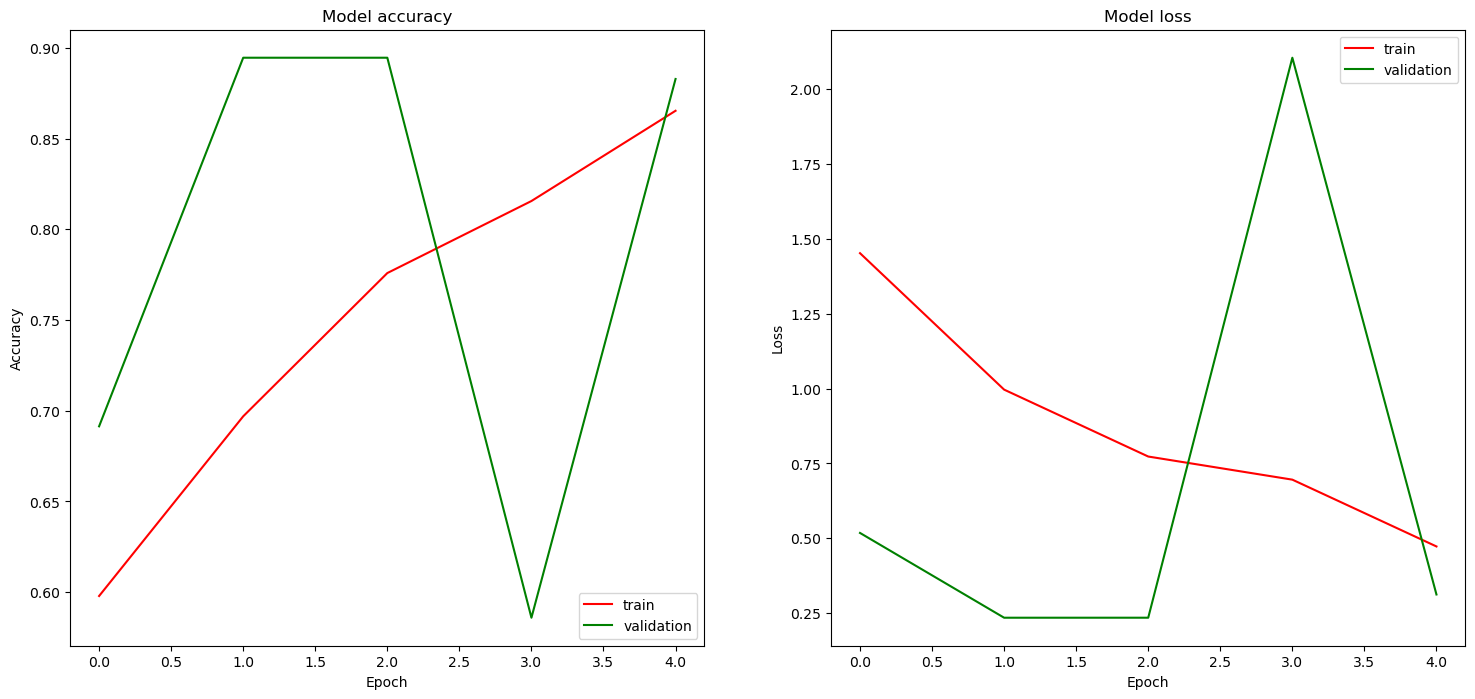

In [7]:
from matplotlib import pyplot as plt
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# accuracy
ax1.plot(history.history['accuracy'], color='red')
ax1.plot(history.history['val_accuracy'], color='green')
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'validation'], loc='lower right')

# "Loss"
ax2.plot(history.history['loss'], color='red')
ax2.plot(history.history['val_loss'], color='green')
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'validation'], loc='upper right')
plt.show()

# Test new model

In [8]:
test_path = "C:\\Users\\David Salazar\\Desktop\\Python\\Pendiction\\Data\\goalie_pens\\test"
test = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path, 
    target_size=(HEIGHT,WIDTH), batch_size=16, class_mode='categorical', shuffle=False)
step_size_test = test.n//test.batch_size

Found 270 images belonging to 3 classes.


# ~86% accuracy on training dataset

In [9]:
model.evaluate(test, steps=step_size_test)

16/16 [==============================] - 91s 6s/step - loss: 0.3089 - accuracy: 0.8633


[0.3089057207107544, 0.86328125]

In [10]:
Y_Pred = model.predict(test, steps=step_size_test+1)
y_pred = np.argmax(Y_Pred, axis=1)

17/17 [==============================] - 101s 6s/step


<AxesSubplot:>

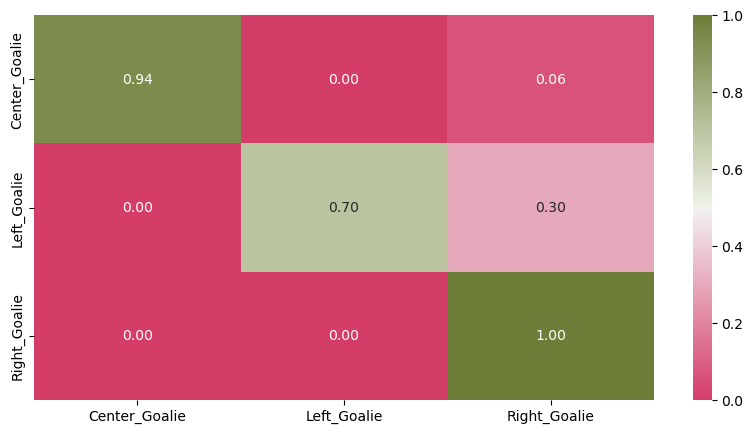

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test.classes, y_pred)

#Normalize data
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmn = np.around(cmn, decimals=2)
fig, ax = plt.subplots(figsize=(10,5))
cmap = sns.diverging_palette(0, 100, as_cmap=True)
sns.heatmap(cmn, annot=True, fmt='.2f',cmap=cmap, xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())